## Benefits and limitations of using gate grouping or "cat entanglements"

This notebook analyses the improvement in entanglement requirements gained by teleporting gates on groups extending over a number of time steps.

In [19]:
from qiskit.circuit.library import QFT
from disqco.circuits.cp_fraction import cp_fraction
from qiskit import transpile
from QASMBench.interface.qiskit import QASMBenchmark
from disqco.graphs.quantum_network import QuantumNetwork


num_qubits = 10

circuit = cp_fraction(num_qubits, num_qubits, fraction=0.5)

# circuit = QFT(num_qubits, do_swaps=False)

num_partitions = 2 # Define the number of partitions or QPUs you will distribute over

qpu_size = num_qubits // num_partitions + 1 # Define the number of qubits per QPU. For simplicity, we divide qubits evenly and add one additional space to each for teleportation (an extra space is needed for the teleportation qubit so the algorithmr requires it!)
qpu_sizes = [qpu_size] * num_partitions # Store the number of qubits per QPU in a list

quantum_network = QuantumNetwork(qpu_sizes)

basis_gates = ['u', 'cp']

# Transpile the circuit to the basis gates
circuit = transpile(circuit, basis_gates=basis_gates)


# Graph conversion

We now convert the circuit to the GCP Hypergraph using a number of predefined functions which can be found in the src code.

We first start by converting to a graph with the group_gates argument set to false, will which give a simplified graph showing interaction over time.

We also defined a "graph_grouped" object, where group_gates is set to true, such that we merge gate edges into hyper-edges where applicable.

In [20]:
from disqco.graphs.QC_hypergraph import QuantumCircuitHyperGraph
from disqco.parti.FM.FM_methods import set_initial_partition_assignment

depth = circuit.depth()

graph = QuantumCircuitHyperGraph(circuit, group_gates=False, anti_diag=True, map_circuit=True)

graph_grouped = QuantumCircuitHyperGraph(circuit, group_gates=True, anti_diag=True, map_circuit=True)


assignment = set_initial_partition_assignment(graph, quantum_network)


We can view the result as a tikz graph using the draw_graph_tikz function, and an "assignment" list which tells us which QPU each qubit is allocated to. The second figure shows the graph after gate grouping, which should appear somewhat more complex.

The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz


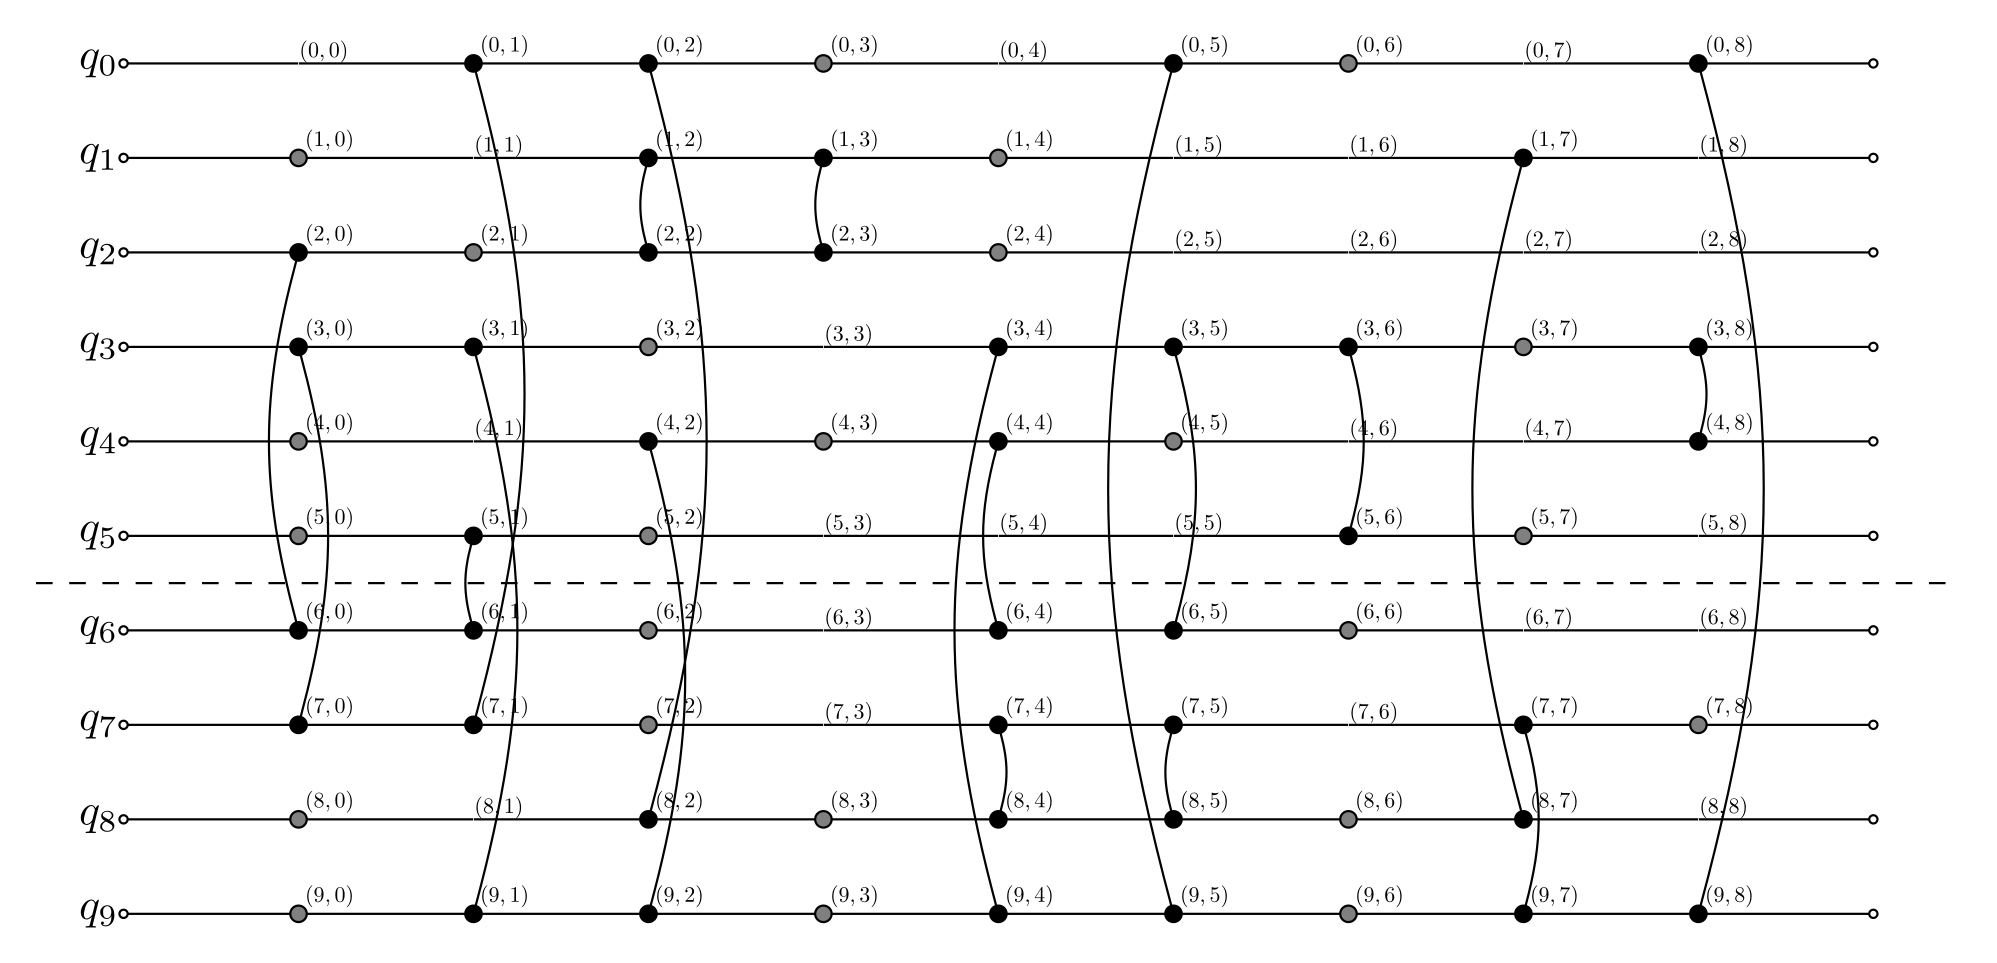

In [21]:
from disqco.drawing.tikz_drawing import draw_graph_tikz
%load_ext jupyter_tikz

graph.draw(network=quantum_network, assignment=assignment)




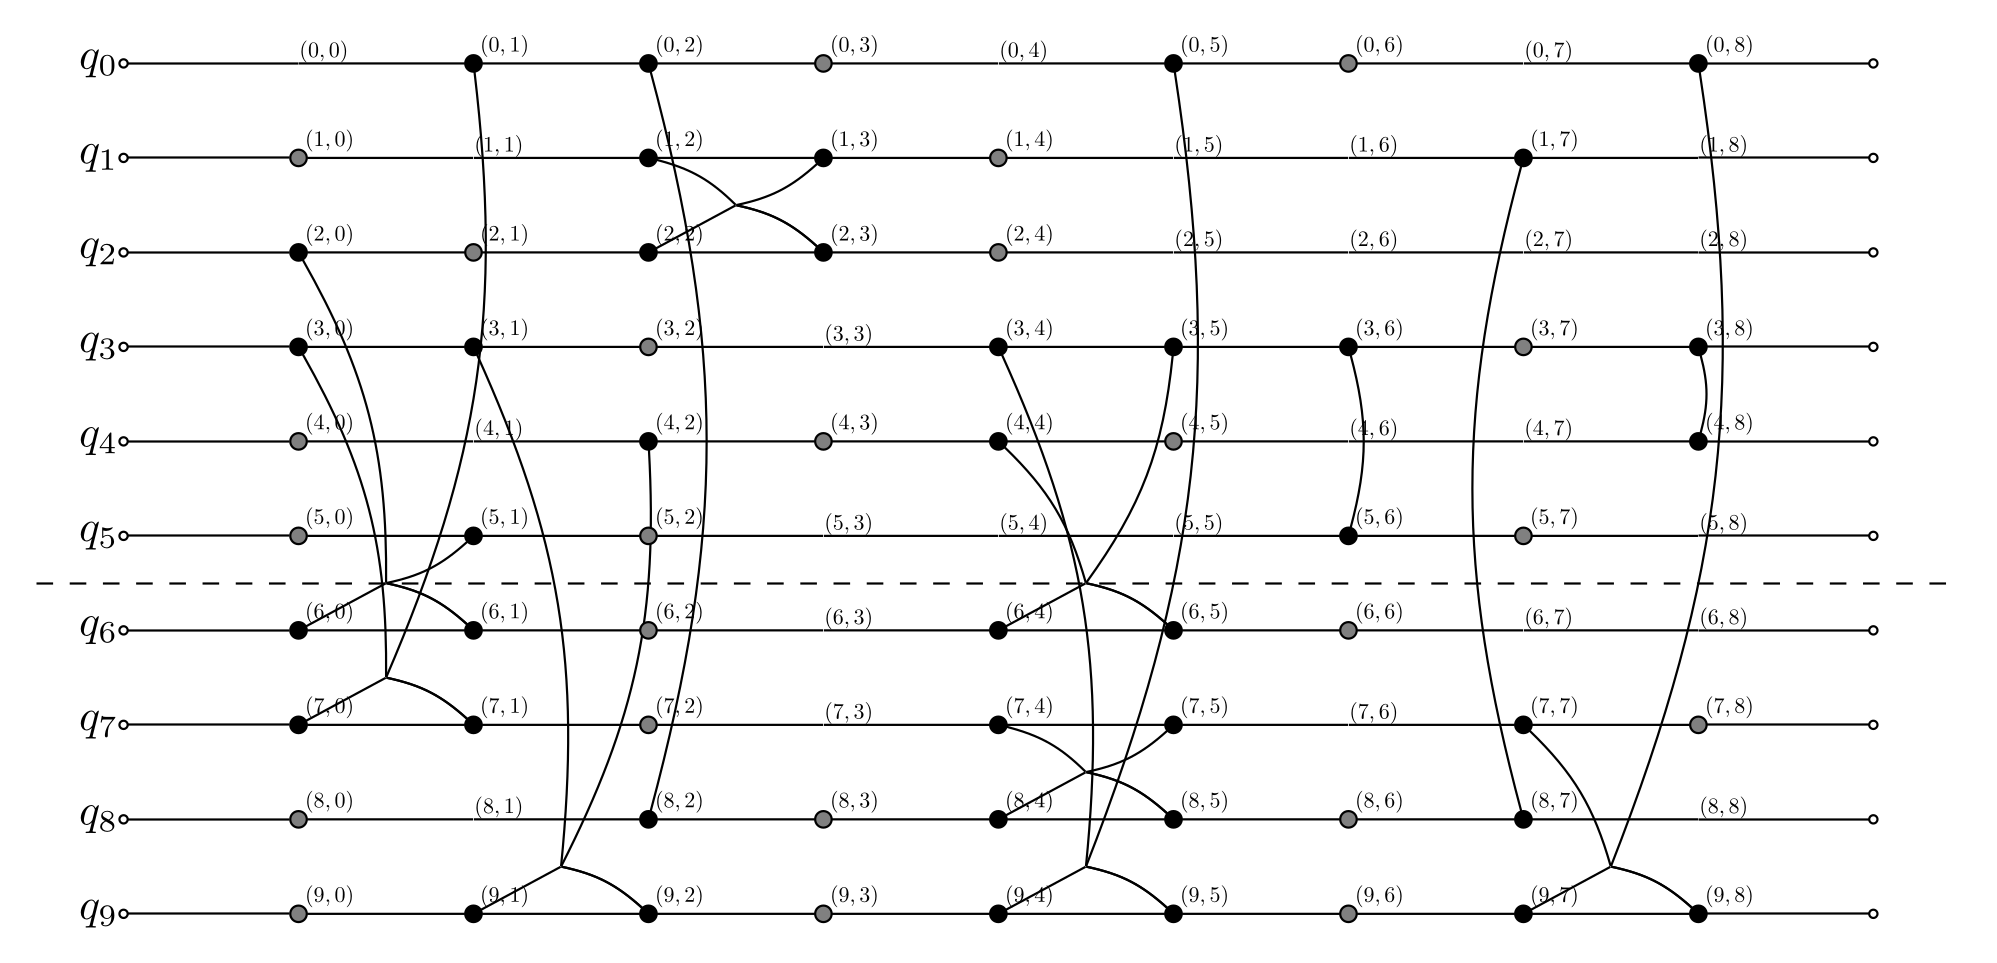

In [22]:
graph_grouped.draw(network=quantum_network, assignment=assignment)


## Partitioning

We partition both graphs using a basic Fiduccia-Mattheyses algorithm. Starting with the ungrouped graph.

In [23]:
from disqco.parti.FM.fiduccia import FiducciaMattheyses

partitioner_ungrouped = FiducciaMattheyses(circuit, quantum_network, assignment, hypergraph=graph)

results = partitioner_ungrouped.partition()

final_cost = results['best_cost']
final_assignment = results['best_assignment']

print(f'Final cost: {final_cost}')


Final cost: 3


If you want you can use the drawing tool to see what the new solution looks like, where the nodes are dragged around to match the assignment. The assignment variable will have to be replaced with final_assignment now! If it's working properly you should see two (or however many partitions you have) sub-graphs which are connected only by the non-local/cutting edges. You can count them to make sure it corresponds to the final cost (although this gets messy for big graphs and when hyper-edge are introduced)

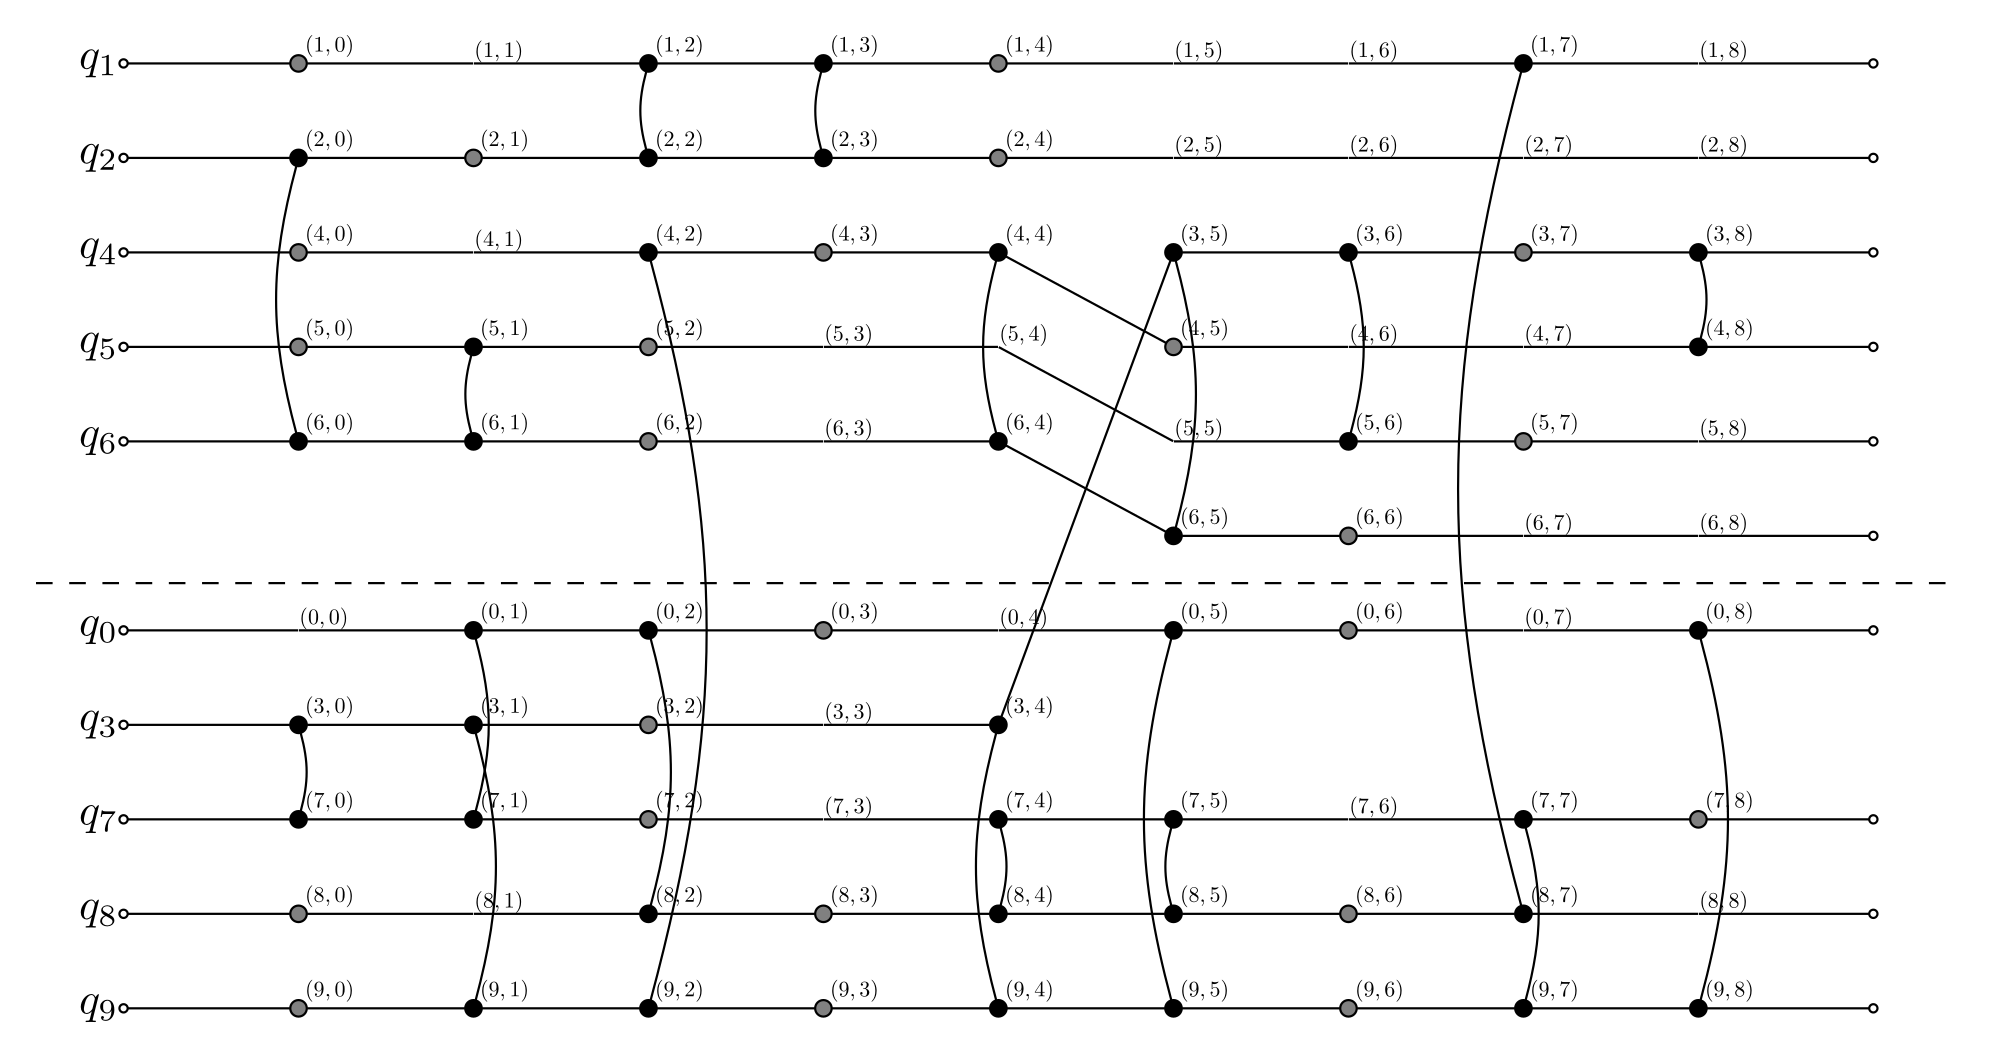

In [24]:
graph.draw(network=quantum_network, assignment=final_assignment)

Now we will optimise the partitioning of the grouped graph, which should give us a lower cost.

In [25]:
partitioner_grouped = FiducciaMattheyses(circuit, quantum_network, assignment, hypergraph=graph_grouped)

results_grouped = partitioner_grouped.partition()
final_cost_grouped = results_grouped['best_cost']
final_assignment_grouped = results_grouped['best_assignment']

print(f'Final cost (grouped): {final_cost_grouped}')

Final cost (grouped): 3


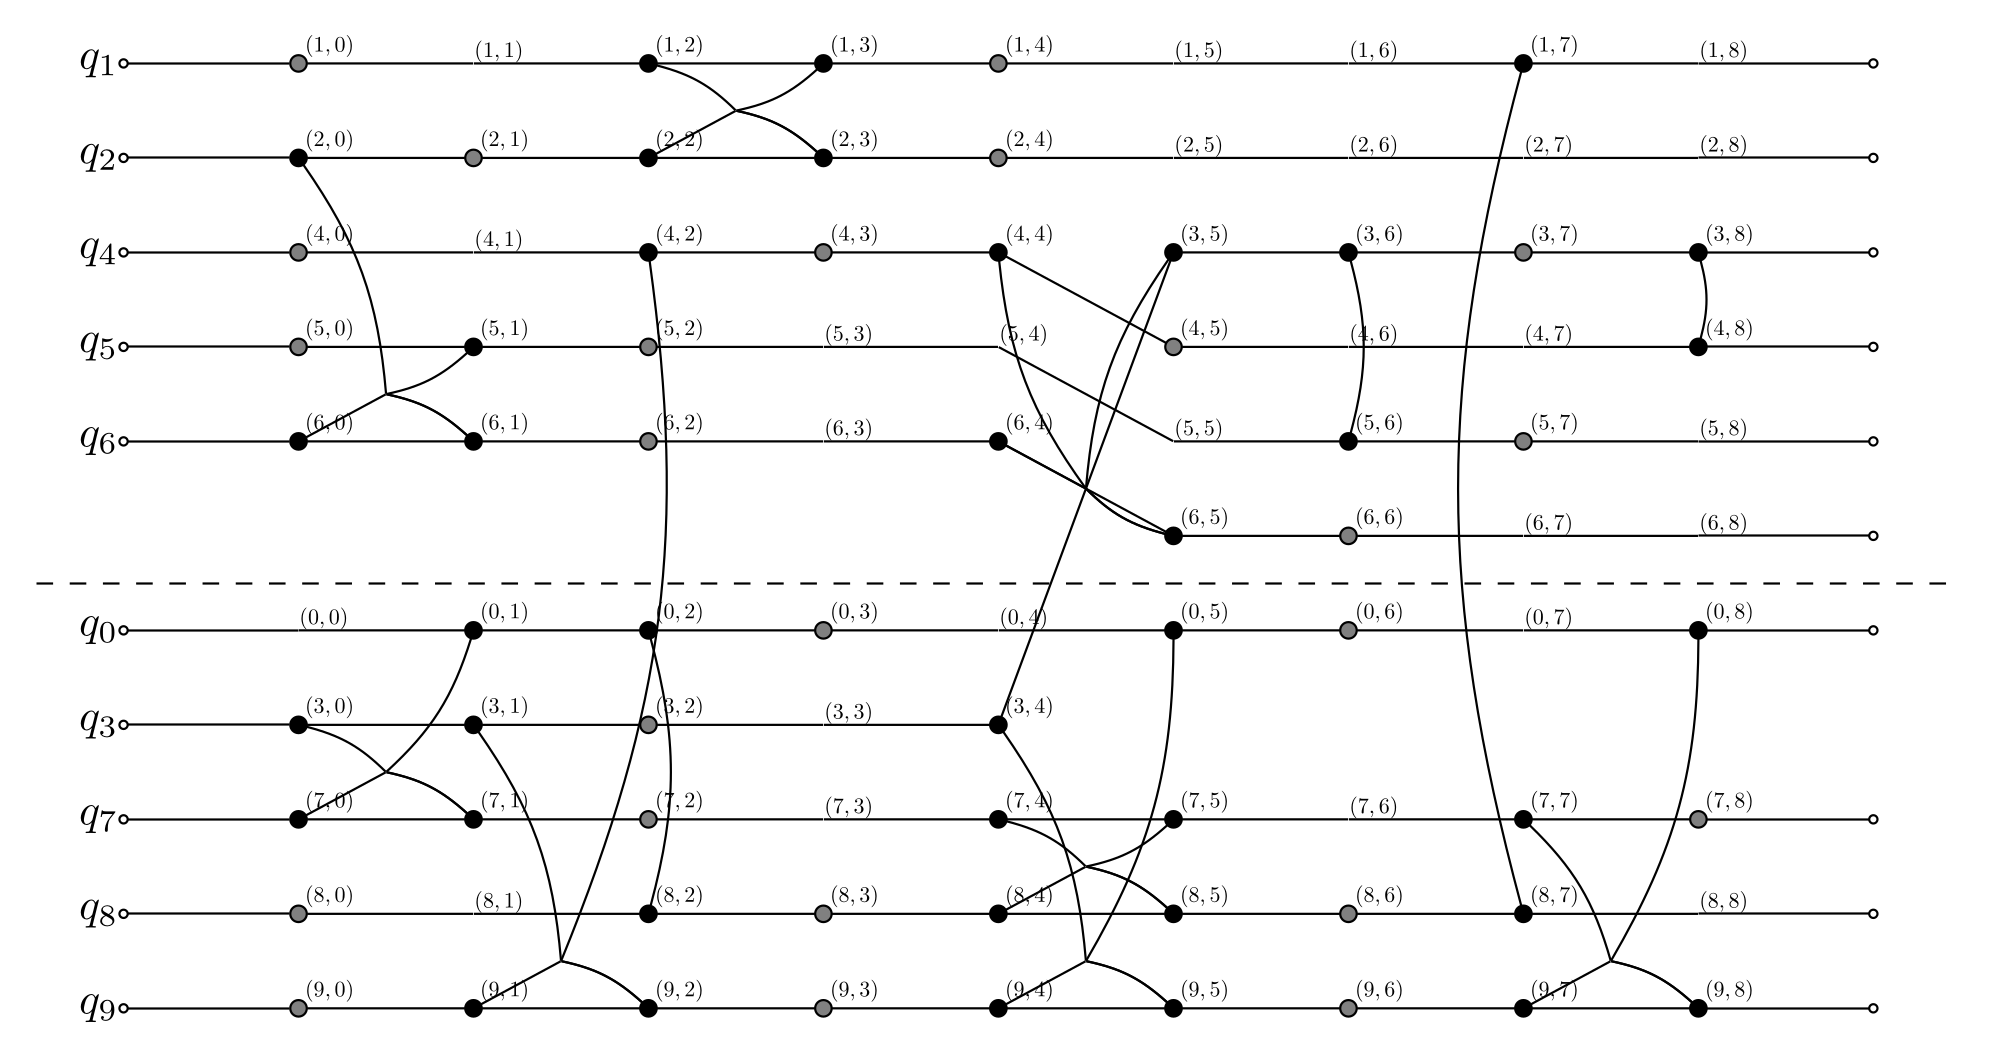

In [26]:
graph_grouped.draw(network=quantum_network, assignment=final_assignment_grouped)

## Circuit extraction

We can see how the additional e-bit costs translate to increased depth of the circuit. As such, gate grouping can implicitly reduce depth of distributed circuits. However, these usually comes at the expense of additional communication qubits, since multiple linked copies of qubits may need to be held at once.

In [27]:
from disqco.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor

extractor = PartitionedCircuitExtractor(graph=graph, 
                                        network=quantum_network,
                                        partition_assignment=final_assignment)

final_circuit = extractor.extract_partitioned_circuit()

Decomposed circuit depth: 55
Number of communication qubits needed: 2


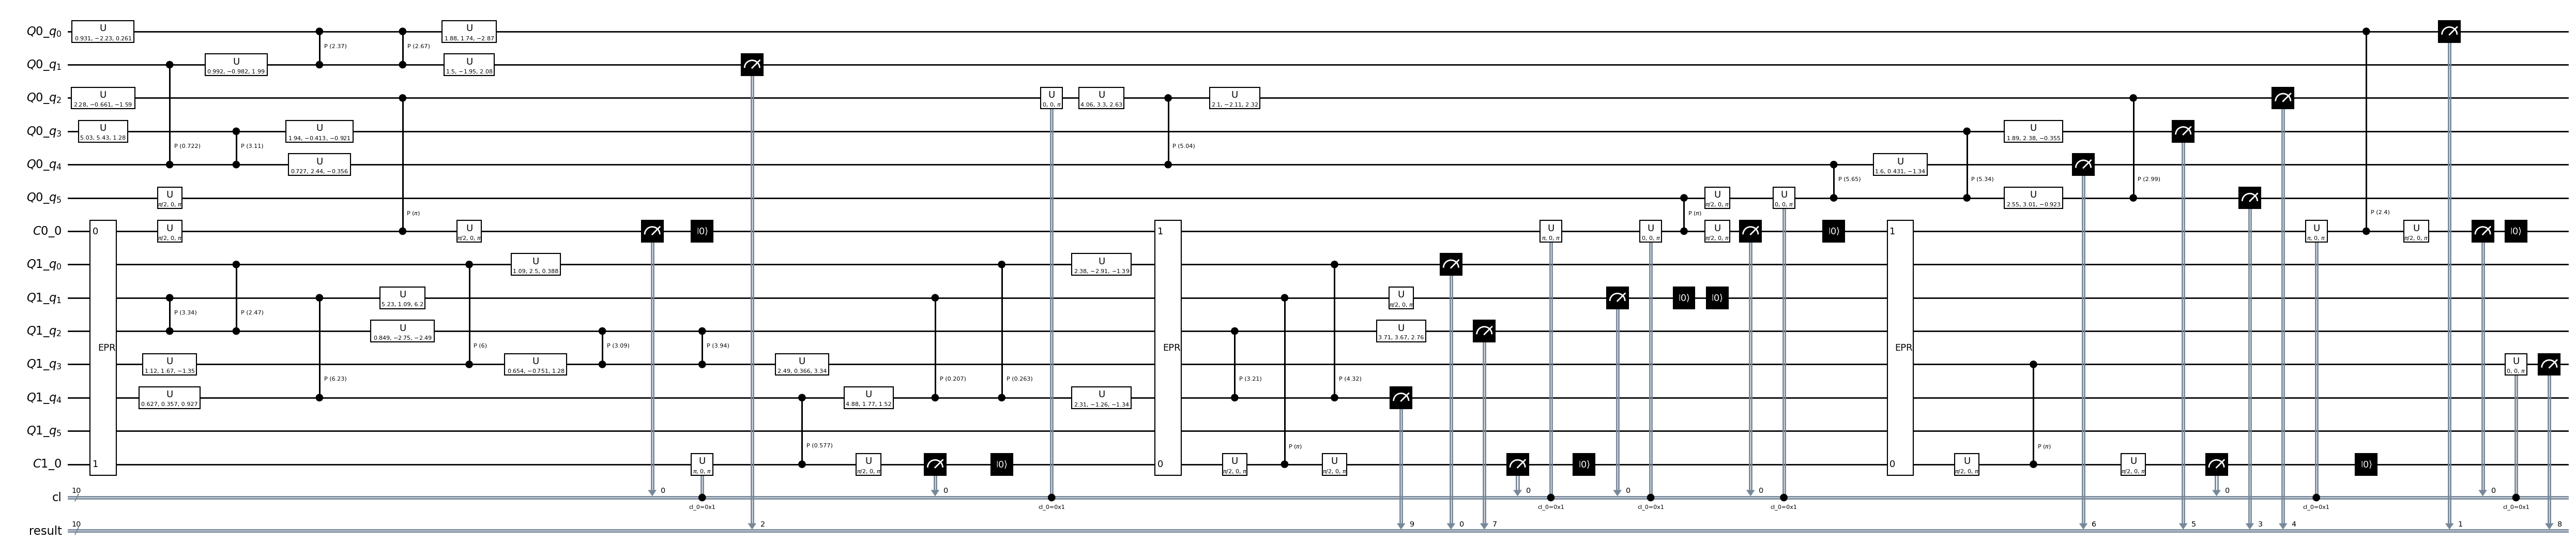

In [28]:

print(f'Decomposed circuit depth: {final_circuit.decompose().decompose().decompose().depth()}')

print(f'Number of communication qubits needed: {final_circuit.num_qubits - sum(qpu_sizes)}')

final_circuit.draw(output='mpl', style = 'bw', fold=100, cregbundle=True) # Draw the circuit



In [29]:

extractor_grouped = PartitionedCircuitExtractor(graph=graph_grouped, 
                                        network=quantum_network,
                                        partition_assignment=final_assignment_grouped)

final_circuit_grouped = extractor_grouped.extract_partitioned_circuit()

Decomposed circuit depth: 57
Number of communication qubits needed: 2


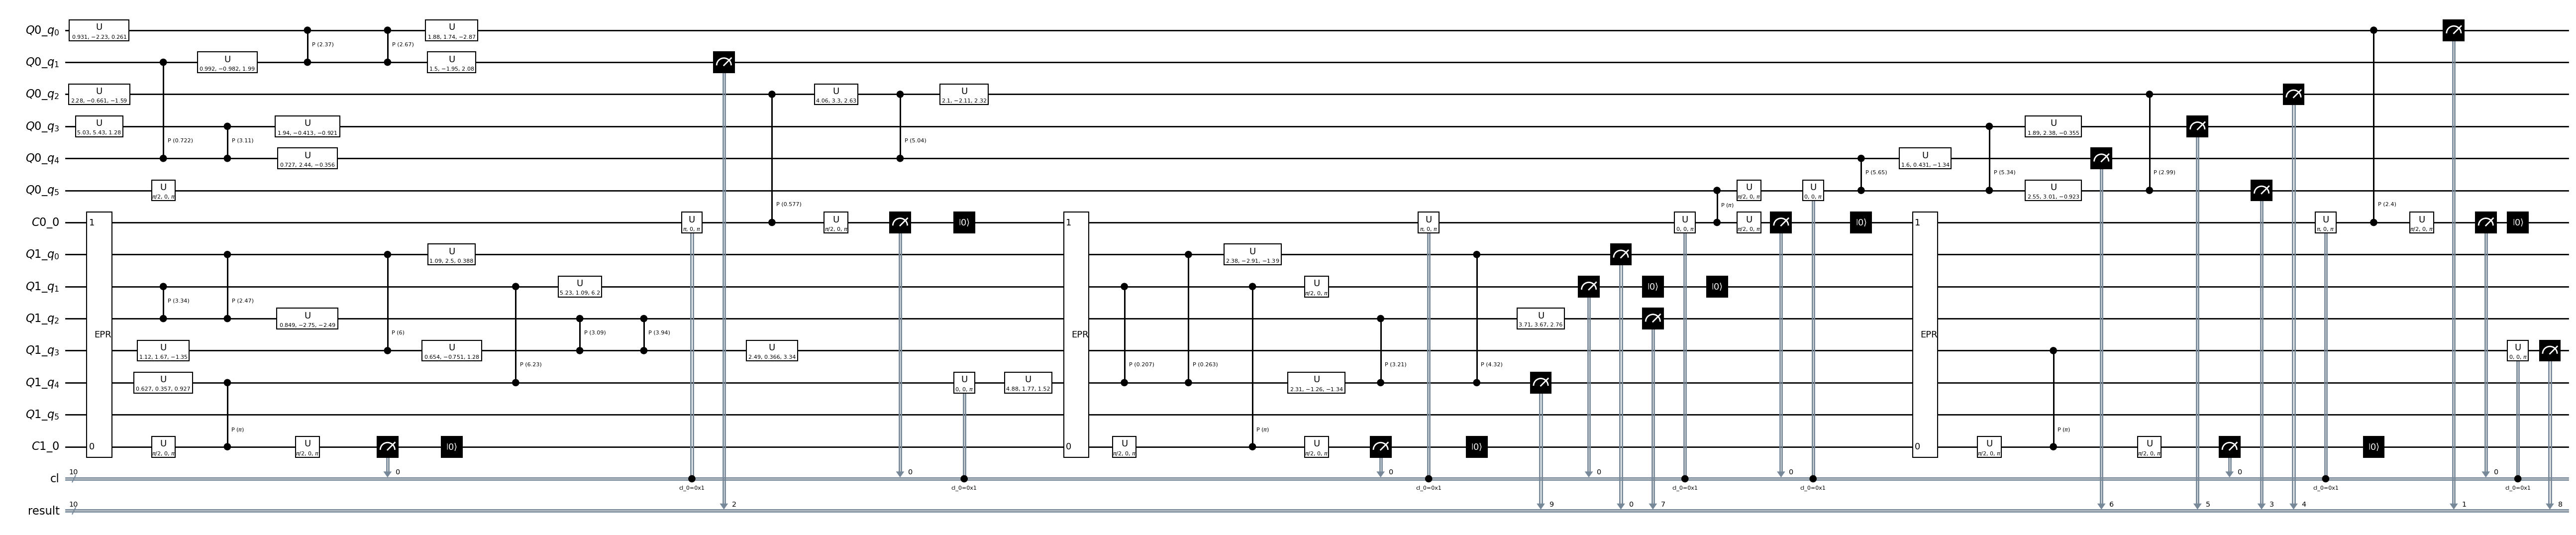

In [30]:

print(f'Decomposed circuit depth: {final_circuit_grouped.decompose().decompose().decompose().depth()}')

print(f'Number of communication qubits needed: {final_circuit_grouped.num_qubits - sum(qpu_sizes)}')

final_circuit_grouped.draw(output='mpl', style = 'bw', fold=100, cregbundle=True) # Draw the circuit

Let's run a quick experiment to analyse this tradeoff.

In [31]:
import numpy as np
num_qubits_list = [16, 24, 32, 40, 48] # Define a list of different numbers of qubits to test

num_partitions = 2

depth_list = []
depth_list_grouped = []

comm_qubits_list = []
comm_qubits_list_grouped = []
iterations = 10
for num_qubits in num_qubits_list:
    qpu_info = [num_qubits // num_partitions + 1] * num_partitions # Store the number of qubits per QPU in a list
    quantum_network = QuantumNetwork(qpu_info)

    depth_list_iteration = []
    depth_list_grouped_iteration = []
    comm_qubits_list_iteration = []
    comm_qubits_list_grouped_iteration = []
    for iteration in range(iterations):
        circuit = cp_fraction(num_qubits, num_qubits, fraction=0.5)
        circuit = transpile(circuit, basis_gates=basis_gates)

        graph = QuantumCircuitHyperGraph(circuit, group_gates=False)
        graph_grouped = QuantumCircuitHyperGraph(circuit, group_gates=True)

        depth = circuit.depth()
        node_counts = len(graph.nodes)
        
        move_limit = node_counts * 0.125
        assignment = set_initial_partition_assignment(graph, quantum_network)
        partitioner_ungrouped = FiducciaMattheyses(circuit, quantum_network, assignment, hypergraph=graph)
        partitioner_grouped = FiducciaMattheyses(circuit, quantum_network, assignment, hypergraph=graph_grouped)

        results_grouped = partitioner_grouped.partition(limit=move_limit)
        results = partitioner_ungrouped.partition(limit=move_limit)

        final_cost_ungrouped = results['best_cost']
        final_assignment_ungrouped = results['best_assignment']

        final_cost_grouped = results_grouped['best_cost']
        final_assignment_grouped = results_grouped['best_assignment']

        extractor = PartitionedCircuitExtractor(graph=graph,
                                                network=quantum_network,
                                                partition_assignment=final_assignment_ungrouped)
        
        final_circuit = extractor.extract_partitioned_circuit()

        extractor_grouped = PartitionedCircuitExtractor(graph=graph_grouped, 
                                                network=quantum_network,
                                                partition_assignment=final_assignment_grouped
                                                )
        
        final_circuit_grouped = extractor_grouped.extract_partitioned_circuit()
    
        circuit_EPR = transpile(final_circuit, basis_gates= basis_gates + ['EPR'])
        circuit_EPR_grouped = transpile(final_circuit_grouped, basis_gates= basis_gates + ['EPR'])

        depth_list_iteration.append(circuit_EPR.depth())
        depth_list_grouped_iteration.append(circuit_EPR_grouped.depth())
        comm_qubits_list_iteration.append(final_circuit.num_qubits - sum(qpu_info))
        comm_qubits_list_grouped_iteration.append(final_circuit_grouped.num_qubits - sum(qpu_info))
    mean_depth = sum(depth_list_iteration) / iterations
    mean_depth_grouped = sum(depth_list_grouped_iteration) / iterations
    mean_comm_qubits = sum(comm_qubits_list_iteration) / iterations
    
    mean_comm_qubits_grouped = sum(comm_qubits_list_grouped_iteration) / iterations
    print(f'Num qubits: {num_qubits}, depth: {mean_depth}, comm qubits: {mean_comm_qubits}')
    print(f'Num qubits: {num_qubits}, depth: {mean_depth_grouped}, comm qubits: {mean_comm_qubits_grouped}')

    depth_list.append(sum(depth_list_iteration) / iterations)
    depth_list_grouped.append(sum(depth_list_grouped_iteration) / iterations)
    comm_qubits_list.append(sum(comm_qubits_list_iteration) / iterations)
    comm_qubits_list_grouped.append(sum(comm_qubits_list_grouped_iteration) / iterations)


Num qubits: 16, depth: 166.9, comm qubits: 2.0
Num qubits: 16, depth: 115.7, comm qubits: 7.3
Num qubits: 24, depth: 424.1, comm qubits: 2.0
Num qubits: 24, depth: 278.1, comm qubits: 11.2
Num qubits: 32, depth: 812.2, comm qubits: 2.0
Num qubits: 32, depth: 475.1, comm qubits: 14.2
Num qubits: 40, depth: 1257.0, comm qubits: 2.0
Num qubits: 40, depth: 773.2, comm qubits: 16.6
Num qubits: 48, depth: 1908.7, comm qubits: 2.0
Num qubits: 48, depth: 1075.7, comm qubits: 20.9


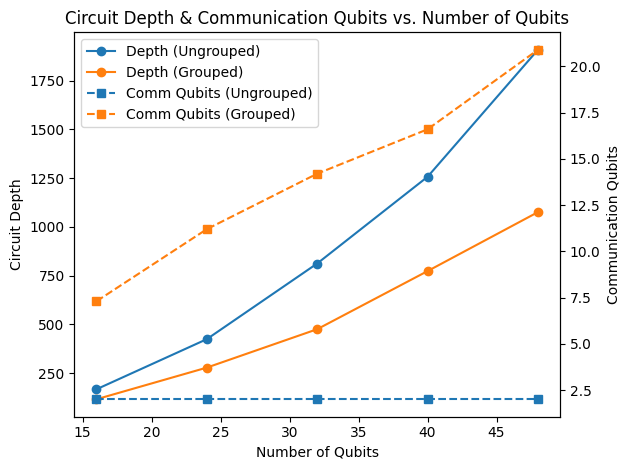

Depth list: [166.9, 424.1, 812.2, 1257.0, 1908.7]
Depth list grouped: [115.7, 278.1, 475.1, 773.2, 1075.7]
Communication qubits list: [2.0, 2.0, 2.0, 2.0, 2.0]
Communication qubits list grouped: [7.3, 11.2, 14.2, 16.6, 20.9]


In [33]:
import matplotlib.pyplot as plt

def plot_depth_and_comm_qubits(num_qubits_list,
                               depth_list, depth_list_grouped,
                               comm_qubits_list, comm_qubits_list_grouped):


    fig, ax_depth = plt.subplots()
    ax_depth.set_xlabel('Number of Qubits')

    # --- Left axis: Depth ---
    ax_depth.set_ylabel('Circuit Depth')
    line_depth_ungrouped, = ax_depth.plot(num_qubits_list, depth_list, marker='o',
                                          label='Depth (Ungrouped)')
    line_depth_grouped, = ax_depth.plot(num_qubits_list, depth_list_grouped, marker='o',
                                        label='Depth (Grouped)')

    # --- Right axis: Communication qubits ---
    ax_comm = ax_depth.twinx()
    ax_comm.set_ylabel('Communication Qubits')
    line_comm_ungrouped, = ax_comm.plot(num_qubits_list, comm_qubits_list, marker='s',
                                        linestyle='--', label='Comm Qubits (Ungrouped)')
    line_comm_grouped, = ax_comm.plot(num_qubits_list, comm_qubits_list_grouped, marker='s',
                                      linestyle='--', label='Comm Qubits (Grouped)')

    # Combine all line objects for a single legend
    lines = [line_depth_ungrouped, line_depth_grouped,
             line_comm_ungrouped, line_comm_grouped]
    labels = [line.get_label() for line in lines]
    ax_depth.legend(lines, labels, loc='best')

    # Give the figure a title, tighten layout, and show
    plt.title('Circuit Depth & Communication Qubits vs. Number of Qubits')
    plt.tight_layout()
    plt.show()

plot_depth_and_comm_qubits(
    num_qubits_list,
    depth_list, depth_list_grouped,
    comm_qubits_list, comm_qubits_list_grouped
)

print(f'Depth list: {depth_list}')
print(f'Depth list grouped: {depth_list_grouped}')
print(f'Communication qubits list: {comm_qubits_list}')
print(f'Communication qubits list grouped: {comm_qubits_list_grouped}')

If we want to go larger, we should use a coarsener for the partitioning

In [34]:
import numpy as np
from disqco.graphs.coarsening.coarsener import HypergraphCoarsener

num_qubits_list = [16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96] # Define a list of different numbers of qubits to test

num_partitions = 2

depth_list = []
depth_list_grouped = []

comm_qubits_list = []
comm_qubits_list_grouped = []
iterations = 10
for num_qubits in num_qubits_list:
    qpu_info = [num_qubits // num_partitions + 1] * num_partitions # Store the number of qubits per QPU in a list
    quantum_network = QuantumNetwork(qpu_info)

    depth_list_iteration = []
    depth_list_grouped_iteration = []
    comm_qubits_list_iteration = []
    comm_qubits_list_grouped_iteration = []
    for iteration in range(iterations):
        circuit = cp_fraction(num_qubits, num_qubits, fraction=0.5)
        circuit = transpile(circuit, basis_gates=basis_gates)

        graph = QuantumCircuitHyperGraph(circuit, group_gates=False)
        graph_grouped = QuantumCircuitHyperGraph(circuit, group_gates=True)

        depth = circuit.depth()
        node_counts = len(graph.nodes)
        
        move_limit = node_counts * 0.125
        assignment = set_initial_partition_assignment(graph, quantum_network)

        partitioner_ungrouped = FiducciaMattheyses(circuit, quantum_network, assignment, hypergraph=graph)
        partitioner_grouped = FiducciaMattheyses(circuit, quantum_network, assignment, hypergraph=graph_grouped)

        results_grouped = partitioner_grouped.partition(hypergraph_coarsener=HypergraphCoarsener.coarsen_recursive_batches)
        results = partitioner_ungrouped.partition(hypergraph_coarsener=HypergraphCoarsener.coarsen_recursive_batches)

        final_cost_ungrouped = results['best_cost']
        final_assignment_ungrouped = results['best_assignment']

        final_cost_grouped = results_grouped['best_cost']
        final_assignment_grouped = results_grouped['best_assignment']

        extractor = PartitionedCircuitExtractor(graph=graph,
                                                network=quantum_network,
                                                partition_assignment=final_assignment_ungrouped)
        
        final_circuit = extractor.extract_partitioned_circuit()

        extractor_grouped = PartitionedCircuitExtractor(graph=graph_grouped, 
                                                network=quantum_network,
                                                partition_assignment=final_assignment_grouped
                                                )
        
        final_circuit_grouped = extractor_grouped.extract_partitioned_circuit()
    
        circuit_EPR = transpile(final_circuit, basis_gates= basis_gates + ['EPR'])
        circuit_EPR_grouped = transpile(final_circuit_grouped, basis_gates= basis_gates + ['EPR'])

        depth_list_iteration.append(circuit_EPR.depth())
        depth_list_grouped_iteration.append(circuit_EPR_grouped.depth())
        comm_qubits_list_iteration.append(final_circuit.num_qubits - sum(qpu_info))
        comm_qubits_list_grouped_iteration.append(final_circuit_grouped.num_qubits - sum(qpu_info))
    mean_depth = sum(depth_list_iteration) / iterations
    mean_depth_grouped = sum(depth_list_grouped_iteration) / iterations
    mean_comm_qubits = sum(comm_qubits_list_iteration) / iterations
    
    mean_comm_qubits_grouped = sum(comm_qubits_list_grouped_iteration) / iterations
    print(f'Num qubits: {num_qubits}, depth: {mean_depth}, comm qubits: {mean_comm_qubits}')
    print(f'Num qubits: {num_qubits}, depth: {mean_depth_grouped}, comm qubits: {mean_comm_qubits_grouped}')

    depth_list.append(sum(depth_list_iteration) / iterations)
    depth_list_grouped.append(sum(depth_list_grouped_iteration) / iterations)
    comm_qubits_list.append(sum(comm_qubits_list_iteration) / iterations)
    comm_qubits_list_grouped.append(sum(comm_qubits_list_grouped_iteration) / iterations)


Num qubits: 16, depth: 155.6, comm qubits: 2.0
Num qubits: 16, depth: 84.6, comm qubits: 6.3
Num qubits: 24, depth: 373.3, comm qubits: 2.0
Num qubits: 24, depth: 218.6, comm qubits: 10.1
Num qubits: 32, depth: 694.4, comm qubits: 2.0
Num qubits: 32, depth: 355.4, comm qubits: 13.4
Num qubits: 40, depth: 1120.3, comm qubits: 2.0
Num qubits: 40, depth: 565.7, comm qubits: 15.2
Num qubits: 48, depth: 1596.1, comm qubits: 2.0
Num qubits: 48, depth: 822.4, comm qubits: 17.7
Num qubits: 56, depth: 2230.0, comm qubits: 2.0
Num qubits: 56, depth: 1105.2, comm qubits: 19.9
Num qubits: 64, depth: 2921.3, comm qubits: 2.0
Num qubits: 64, depth: 1451.1, comm qubits: 22.7
Num qubits: 72, depth: 3705.1, comm qubits: 2.0
Num qubits: 72, depth: 1778.7, comm qubits: 25.8
Num qubits: 80, depth: 4636.8, comm qubits: 2.0
Num qubits: 80, depth: 2180.8, comm qubits: 28.2
Num qubits: 88, depth: 5569.0, comm qubits: 2.0
Num qubits: 88, depth: 2610.8, comm qubits: 29.6
Num qubits: 96, depth: 6688.5, comm qubi

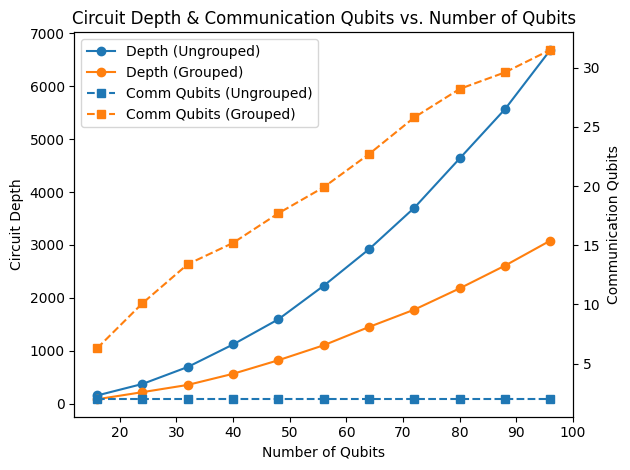

Depth list: [155.6, 373.3, 694.4, 1120.3, 1596.1, 2230.0, 2921.3, 3705.1, 4636.8, 5569.0, 6688.5]
Depth list grouped: [84.6, 218.6, 355.4, 565.7, 822.4, 1105.2, 1451.1, 1778.7, 2180.8, 2610.8, 3083.6]
Communication qubits list: [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
Communication qubits list grouped: [6.3, 10.1, 13.4, 15.2, 17.7, 19.9, 22.7, 25.8, 28.2, 29.6, 31.5]


In [35]:
import matplotlib.pyplot as plt

def plot_depth_and_comm_qubits(num_qubits_list,
                               depth_list, depth_list_grouped,
                               comm_qubits_list, comm_qubits_list_grouped):


    fig, ax_depth = plt.subplots()
    ax_depth.set_xlabel('Number of Qubits')

    # --- Left axis: Depth ---
    ax_depth.set_ylabel('Circuit Depth')
    line_depth_ungrouped, = ax_depth.plot(num_qubits_list, depth_list, marker='o',
                                          label='Depth (Ungrouped)')
    line_depth_grouped, = ax_depth.plot(num_qubits_list, depth_list_grouped, marker='o',
                                        label='Depth (Grouped)')

    # --- Right axis: Communication qubits ---
    ax_comm = ax_depth.twinx()
    ax_comm.set_ylabel('Communication Qubits')
    line_comm_ungrouped, = ax_comm.plot(num_qubits_list, comm_qubits_list, marker='s',
                                        linestyle='--', label='Comm Qubits (Ungrouped)')
    line_comm_grouped, = ax_comm.plot(num_qubits_list, comm_qubits_list_grouped, marker='s',
                                      linestyle='--', label='Comm Qubits (Grouped)')

    # Combine all line objects for a single legend
    lines = [line_depth_ungrouped, line_depth_grouped,
             line_comm_ungrouped, line_comm_grouped]
    labels = [line.get_label() for line in lines]
    ax_depth.legend(lines, labels, loc='best')

    # Give the figure a title, tighten layout, and show
    plt.title('Circuit Depth & Communication Qubits vs. Number of Qubits')
    plt.tight_layout()
    plt.show()

plot_depth_and_comm_qubits(
    num_qubits_list,
    depth_list, depth_list_grouped,
    comm_qubits_list, comm_qubits_list_grouped
)

print(f'Depth list: {depth_list}')
print(f'Depth list grouped: {depth_list_grouped}')
print(f'Communication qubits list: {comm_qubits_list}')
print(f'Communication qubits list grouped: {comm_qubits_list_grouped}')